### CNN 기법을 이용한 물고기 품종 인식

In [102]:
# 글꼴 설치전 런타임 환경 확인
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

In [103]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/fish' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [104]:
height=80
width=128

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/train', # 파일이 있는 폴더, Colab은 절대 경로 명시해야 인식가능 
train_generator = train_datagen.flow_from_directory(
        './train', # 파일이 있는 폴더, Colab은 절대 경로 명시해야 인식가능 
        target_size=(height, width), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/validation',
vali_generator = vali_datagen.flow_from_directory(
        './validation',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 24 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [105]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(4, activation='softmax'))
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

cp = ModelCheckpoint(filepath='./Fish.h5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

start = time.time()

hist = model.fit(
    train_generator,
    epochs=50,
    validation_data = vali_generator,
    callbacks=[cp, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# Total params: 118,282 Colab gpu: 42 ~ 83s, i5 2320: 117s, gtx 1060: 20s


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 80, 128, 32)       896       
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 128, 32)       9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 81920)             0         
                                                                 
 dense_12 (Dense)            (None, 30)                2457630   
                                                                 
 dense_13 (Dense)            (None, 4)                 124       
                                                      

24/24 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 1.0000
Epoch 25: val_accuracy did not improve from 0.91667
24/24 [==============================] - 1s 33ms/step - loss: 0.1143 - accuracy: 1.0000 - val_loss: 0.3664 - val_accuracy: 0.9167
Epoch 26/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0956 - accuracy: 1.0000
Epoch 26: val_accuracy improved from 0.91667 to 1.00000, saving model to .\Fish.h5
24/24 [==============================] - 2s 75ms/step - loss: 0.0918 - accuracy: 1.0000 - val_loss: 0.3184 - val_accuracy: 1.0000
Epoch 27/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0686 - accuracy: 1.0000
Epoch 27: val_accuracy did not improve from 1.00000
24/24 [==============================] - 1s 34ms/step - loss: 0.0706 - accuracy: 1.0000 - val_loss: 0.3704 - val_accuracy: 0.9167
Epoch 28/50
23/24 [===========================>..] - ETA: 0s - loss: 0.0619 - accuracy: 1.0000
Epoch 28: val_accuracy did not improve from 1.00000
24/

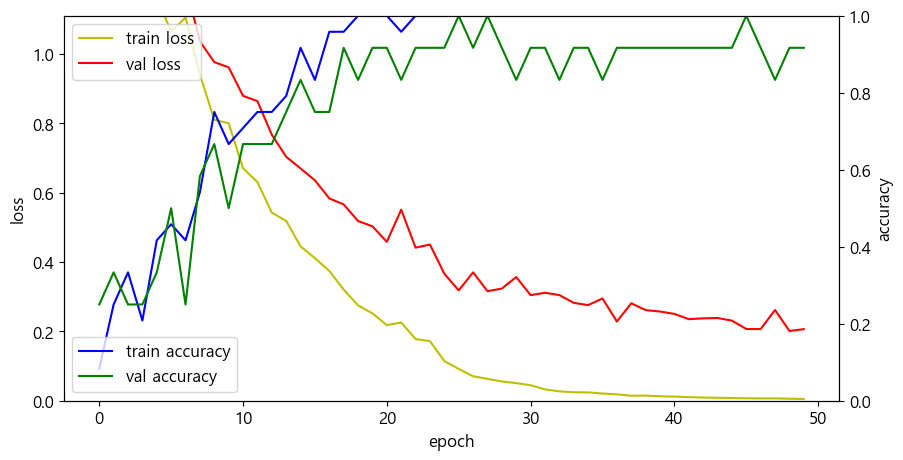

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.1110]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [107]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 91.67%


In [108]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 70개, 7개의 분류임으로 출력은 70행 7열
print(output)

-- Predict --
{'bunga': 0, 'kwanga': 1, 'samchi': 2, 'wooruk': 3}
<class 'numpy.ndarray'>
(12, 4)
[[0.022 0.000 0.914 0.064]
 [0.000 0.000 0.993 0.007]
 [0.953 0.000 0.002 0.045]
 [0.009 0.001 0.009 0.981]
 [0.000 0.993 0.003 0.004]
 [0.117 0.000 0.712 0.170]
 [0.034 0.351 0.042 0.572]
 [0.767 0.000 0.044 0.189]
 [0.003 0.023 0.065 0.909]
 [0.576 0.000 0.094 0.330]
 [0.002 0.000 0.007 0.991]
 [0.000 0.999 0.001 0.000]]


In [109]:
# model.save('/content/drive/My Drive/kd_ml/cnn/fish/Fish.h5')

In [110]:
# model = load_model('/content/drive/My Drive/kd_ml/cnn/fish/Fish.h5')
model = load_model('./Fish.h5')

In [111]:
# {'kwanga': 0, 'megi': 1, 'samchi': 2, 'wooruk': 3}
def display(data):
    if np.max(data) >= 0.6: # 확신이 있는 결과만 처리
        sw= np.argmax(data)

        if sw == 0:
            sw = '붕어'
        elif sw == 1:
            sw = '광어'
        elif sw == 2:
            sw = '삼치'
        elif sw == 3:
            sw = '우럭'
    else:
        sw = '품종을 알수없습니다.'  
        
    return sw    

In [112]:
# 테스트용 데이터 생성기
# {'kwanga': 0, 'samchi': 1, 'wooruk': 2}
test_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/test1',
test_generator = test_datagen.flow_from_directory(
        './test1',
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp*100)
print('타겟: 광어 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.255 89.873 8.536 1.336]]
타겟: 광어 / 광어


In [113]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/test2',
test_generator = test_datagen.flow_from_directory(
        './test2',
        target_size=(height, width),   
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp*100)
print('타겟: 삼치 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[2.321 0.009 86.020 11.650]]
타겟: 삼치 / 삼치


In [114]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/test3',
test_generator = test_datagen.flow_from_directory(
        './test3',
        target_size=(height, width), 
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp*100)
print('타겟: 우럭 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[7.770 0.447 8.812 82.971]]
타겟: 우럭 / 우럭


In [117]:
# 훈련하지 않은 데이터 '쭈꾸미'의 사용
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/test4',
test_generator = test_datagen.flow_from_directory(
        './test4',
        target_size=(height, width), 
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp*100)
print('타겟: 붕어 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[93.242 0.001 1.829 4.929]]
타겟: 붕어 / 붕어


In [118]:
# 훈련하지 않은 데이터 '쭈꾸미'의 사용
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)

# '/content/drive/My Drive/kd_ml/cnn/fish/test5',
test_generator = test_datagen.flow_from_directory(
        './test5',
        target_size=(height, width),
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp*100)
print('타겟: 쭈꾸미 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[50.633 0.249 21.950 27.168]]
타겟: 쭈꾸미 / 품종을 알수없습니다.
